<a href="https://colab.research.google.com/github/PandeeswariShan029/Hyperlink-extraction-for-url-phishing-detection-using-lstm/blob/main/Phishing_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#importing all necessary libraries(numpy, os, cv2, matplolib, keras)
import numpy as np
import os
import cv2
from keras import layers
from keras.layers import Input, Dense, Add,Activation, AveragePooling2D, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout, ZeroPadding2D
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.initializers import glorot_uniform
from keras import regularizers
import scipy.misc
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

/usr/local/lib/python3.9/dist-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_gen = ImageDataGenerator(rotation_range=50,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='constant',
                                    cval=0,
                                    rescale=1./255)
valid_data_gen = ImageDataGenerator(rotation_range=45,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='constant',
                                    cval=0,
                                    rescale=1./255)

test_data_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
dataset_dir = os.path.join("/content/drive/MyDrive/Datasets/", 'Data')

Batch_size = 8
img_h = 256
img_w = 256
num_classes=2

classes = ['Legitimate','phishing']
# Training
SEED = 1234
import tensorflow as tf
tf.random.set_seed(SEED) 

training_dir = os.path.join(dataset_dir, 'Train')

In [ ]:
train_gen = train_data_gen.flow_from_directory(training_dir,
                                               target_size=(256, 256),
                                               batch_size=Batch_size,
                                               classes=classes,
                                               class_mode='binary',
                                               shuffle=True,
                                               seed=SEED)  # targets are directly converted into one-hot vectors

Found 1237 images belonging to 2 classes.


In [ ]:
# Validation
valid_dir = os.path.join(dataset_dir, 'Test')
valid_gen = valid_data_gen.flow_from_directory(valid_dir,
                                           target_size=(256, 256),
                                           batch_size=Batch_size, 
                                           classes=classes,
                                           class_mode='binary',
                                           shuffle=False,
                                           seed=SEED)
# Test
test_dir = os.path.join(dataset_dir, 'Test')
test_gen = test_data_gen.flow_from_directory(test_dir,
                                             target_size=(256, 256),
                                             batch_size=10, 
                                             shuffle=False,
                                             seed=SEED,
                                             class_mode=None,
                                             )
CLASS_NAMES = np.array(['Legitimate','phishing'], dtype='<U10')

Found 450 images belonging to 2 classes.
Found 509 images belonging to 2 classes.


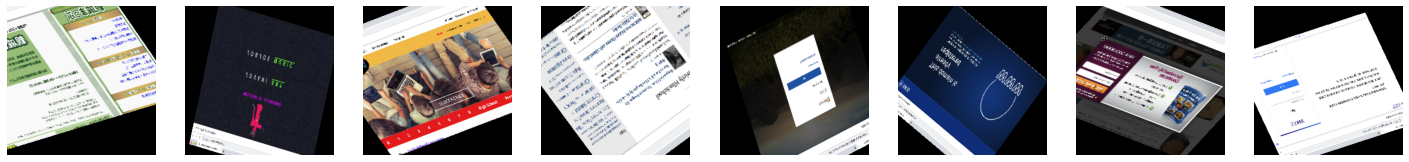

In [ ]:
import matplotlib.pyplot as plt

def show_batch(image_batch, label_batch):
  plt.figure(figsize=(25,20))
  for n in range(8):
      ax = plt.subplot(1,8,n+1)
      plt.imshow(image_batch[n])
      #plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')
      
image_batch, label_batch = next(train_gen)
show_batch(image_batch, label_batch)

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
from tensorflow.keras.optimizers import Adam

In [ ]:
from tensorflow.keras import Model 
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

In [ ]:
ResNet_model = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))
for layer in ResNet_model.layers[:-15]:
    layer.trainable = False

x = ResNet_model.output
x = L.Conv1D(filters = 8, kernel_size = 3, padding = "same", strides = 1)(x)
x = L.BatchNormalization()(x)
x = L.Activation("relu")(x)
x = L.Conv1D(filters = 8, kernel_size = 3, padding = "same", strides = 1)(x)
x = L.BatchNormalization()(x)
x = L.Activation("relu")(x)
x_s = x
x = L.Conv1D(filters = 8, kernel_size = 3, padding = "same", strides = 1)(x)
x = L.BatchNormalization()(x)
x = L.Activation("relu")(x)   
x = L.Conv1D(filters = 8, kernel_size = 3, padding = "same", strides = 1)(x)
x = L.BatchNormalization()(x)
x = L.Activation("relu")(x) 
x = L.Flatten()(x)
x = Dense(20, activation = "relu")(x)
x = tf.expand_dims(x, axis=-1)
x = L.LSTM(8,return_sequences=True)(x)
x = L.Flatten()(x)
x = L.BatchNormalization()(x)
x = L.Dropout(0.01)(x)
output = L.Dense(1, activation = "sigmoid")(x)
model = Model(ResNet_model.input,output)


#model.summary()
loss = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss, metrics= ['accuracy'])

234545216/234545216 [==============================] - 2s 0us/step


In [ ]:
transfer_learning_history = model.fit_generator(generator=train_gen,
                   steps_per_epoch=10,
                   validation_data=valid_gen,
                   epochs=5)

<ipython-input-11-61b9e417bcfb>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  transfer_learning_history = model.fit_generator(generator=train_gen,


Epoch 1/5
10/10 [==============================] - 256s 26s/step - loss: 0.7253 - accuracy: 0.5750 - val_loss: 0.6552 - val_accuracy: 0.8889
Epoch 2/5
10/10 [==============================] - 238s 26s/step - loss: 0.6567 - accuracy: 0.6500 - val_loss: 0.5633 - val_accuracy: 1.0000
Epoch 3/5
10/10 [==============================] - 239s 26s/step - loss: 0.5475 - accuracy: 0.8000 - val_loss: 0.5014 - val_accuracy: 1.0000
Epoch 4/5
10/10 [==============================] - 220s 24s/step - loss: 0.5505 - accuracy: 0.7750 - val_loss: 0.4403 - val_accuracy: 1.0000
Epoch 5/5
10/10 [==============================] - 220s 24s/step - loss: 0.4568 - accuracy: 0.8750 - val_loss: 0.3984 - val_accuracy: 1.0000


In [ ]:
model.save('model.h5')

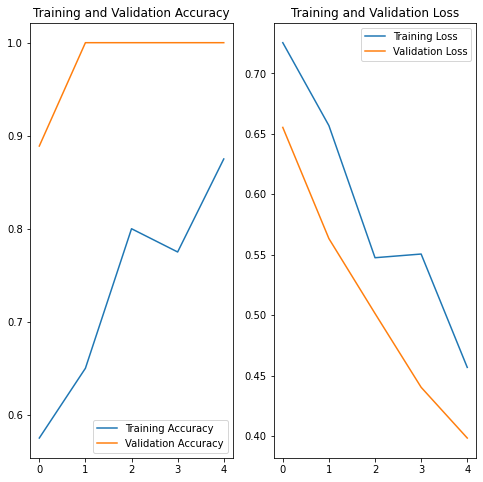

In [ ]:
import matplotlib.pyplot as plt
acc = transfer_learning_history.history['accuracy']
val_acc = transfer_learning_history.history['val_accuracy']
loss = transfer_learning_history.history['loss']
val_loss = transfer_learning_history.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
STEP_SIZE_TEST=test_gen.n//test_gen.batch_size
test_gen.reset()
pred=model.predict(test_gen,
steps=STEP_SIZE_TEST,
verbose=1)

50/50 [==============================] - 197s 4s/step


In [ ]:
import pandas as pd
labels = train_gen.class_indices
labels = dict((v,k) for k,v in labels.items())
filenames=test_gen.filenames
FN=[]
for i in filenames:
  FN.append(i)
y_test = []
for i in filenames:
  y_test.append(i.split('/')[0])
y_values = []
for i in y_test:
  if "Legitimate" == i:
    ii =0
    y_values.append(ii)
  else:
    iii=1
    y_values.append(iii)

In [ ]:
y_pred =[]
for i in filenames:
  image = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/Datasets/Data/Test/"+i,target_size= (256,256,3))
  input_arr = tf.keras.preprocessing.image.img_to_array(image)
  input_arr = np.array([input_arr])  # Convert single image to a batch.
  predictions = model.predict(input_arr)
  y_pred.append(np.argmax(predictions ,axis=1))

NameError: ignored

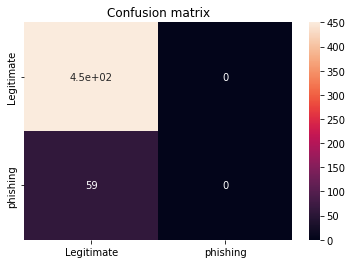

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
CM = confusion_matrix(y_values, y_pred)
ax = plt.axes()
class_names = ['Legitimate','phishing']
sns.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [ ]:
from sklearn import metrics
traccuracy=metrics.accuracy_score(y_values, y_pred)
trf1_score=metrics.f1_score(y_values, y_pred,average='macro')
trprecision_score=metrics.precision_score(y_values, y_pred,average='macro')
trrecall_score=metrics.recall_score(y_values, y_pred,average='macro')


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
trdata =[traccuracy,trf1_score,trprecision_score,trrecall_score]
trvalues = ['Accuracy','F1_score','Precision','Recall']
trdatas=zip(trvalues,trdata)
trFinal = pd.DataFrame(trdatas,columns=['Meaurement','values'])
trFinal

,Meaurement,values
0,Accuracy,0.884086
1,F1_score,0.469239
2,Precision,0.442043
3,Recall,0.500000


In [ ]:
### TESTING

image = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/Datasets/Data/Test/Phishing/40401533.png",target_size= (256,256,3))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = model.predict(input_arr) 
y_pred =np.argmax(predictions ,axis=1)
if y_pred =='0':
  print('Legitimate')
else:
  print('phishing')

1/1 [==============================] - 0s 405ms/step
phishing


<ipython-input-20-4995fdfd79a6>:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if y_pred =='0':
